In [1]:
import warnings
warnings.filterwarnings('ignore')
import gzip
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import folium
import shapely
import os

In [2]:
#reimport from xls for Supervised
import pandas as pd
LondonCheckinsClss = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClss.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


# <font color='red'>Supervised Learning ->  </font>
#    <font color='red'>Logistic Regression and Differential Privacy Logistic Regression </font>

So basically I'm going to try and provide data to end user app so they can predict what time customers will come and on what days

## Dummy Encoding for logistic Classification

In [3]:
# removing columns for Classification
LondonCheckinsClss = LondonCheckinsClss.drop(['location_id','check_in_time','checkin_Date'
                                              ,'checkin_time','checkin_year','checkin_day','latitude','longitude'
                                              ,'city_district','Location'
                                             # ,'checkin_month','checkin_weekday','checkin_hour','Address'
                                             # ,'latitude','longitude','user'
                                             ], axis=1)
LondonCheckinsClss.head(3)

,user,checkin_month,checkin_hour,checkin_weekday,Address
0,72,4,7,Sunday,"Sandhurst Road, Catford South, London Borough ..."
1,72,4,16,Friday,"Centrale, Tamworth Road, Broad Green, London B..."
2,72,4,16,Friday,"Centrale, Tamworth Road, Broad Green, London B..."


In [4]:
#one hot encoding for month and weekday 
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_month'], drop_first=True, prefix='month')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_hour'], drop_first=True, prefix='hour')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['Address'], drop_first=True, prefix='Address')
LondonCheckinsClss.head()

,user,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,"Address_West Norwood Library, Norwood High Street, West Norwood, London Borough of Lambeth, London, Brixton, Greater London, England, SE27 9NS, United Kingdom","Address_West Norwood, Hannen Road, West Norwood, London Borough of Lambeth, London, Streatham, Greater London, England, SE27 0DT, United Kingdom","Address_Whitgift Avenue, Haling Park Road, Waddon, London Borough of Croydon, London, Croydon, Greater London, England, CR2 6NF, United Kingdom","Address_Whitgift Centre, Drummond Road, Broad Green, London Borough of Croydon, London, Croydon, Greater London, England, CR0 1TT, United Kingdom","Address_Widmore, London Borough of Bromley, London, Bromley, Greater London, England, BR2 9PF, United Kingdom","Address_Wing Yip, 544, Purley Way, Waddon, London Borough of Croydon, London, Croydon, Greater London, England, CR0 4RE, United Kingdom","Address_Woodham Road, South End, London Borough of Lewisham, London, Catford, Greater London, England, SE6 2SE, United Kingdom","Address_Zizzi, 11 - 13, Widmore Road, Plaistow, London Borough of Bromley, London, Bromley, Greater London, England, BR1 1RL, United Kingdom","Address_Zizzi, 57-59, South End, Waddon, London Borough of Croydon, London, Croydon, Greater London, England, CR0 1BF, United Kingdom","Address_glasseslab, Ringers Road, Shortlands, London Borough of Bromley, London, Bromley, Greater London, England, BR1 1EG, United Kingdom"
0,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
LondonCheckinsClss.shape

(1513, 376)

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    LondonCheckinsClss.drop('user', axis=1), LondonCheckinsClss['user'],
      test_size=0.33, random_state=2021)

In [7]:
y_train.head()

520    17052
442     7675
544    19470
118     4701
415     7675
Name: user, dtype: int64

## Logistic Regression

In [8]:
#Citation :https://github.com/IBM/differential-privacy-library/blob/main/notebooks/logistic_regression.ipynb

from sklearn.linear_model import LogisticRegression
import diffprivlib.models as dp
from sklearn import model_selection
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, zero_one_loss
import numpy as np
from diffprivlib import tools as dptools

## Differential Privacy - Logistic Regression

In [9]:
clss = LogisticRegression(solver="lbfgs")
clss.fit(X_train, y_train)
y_pred_clss = clss.predict(X_test)
y_pred_train_clss = clss.predict(X_train)
clss_error = zero_one_loss(y_test, y_pred_clss)
clss_error_train = zero_one_loss(y_train, y_pred_train_clss)

print("Training set score: %.2f%%" % (clss.score(X_train, y_train) * 100))
print("Training Error: %.2f%%" % ((clss_error_train) * 100))
print("Test set score: %.2f%%" % (clss.score(X_test, y_test) * 100))
print("Error: %.2f%%" % ((clss_error) * 100))

Training set score: 75.62%
Training Error: 24.38%
Test set score: 52.60%
Error: 47.40%


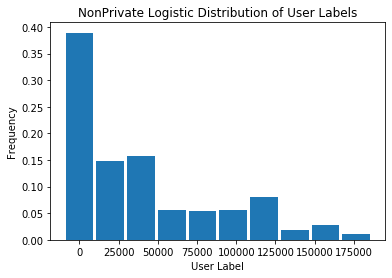

In [10]:
hist, bins = np.histogram( LondonCheckinsClss['user'])
hist = hist / hist.sum()

ax=plt.subplot()

plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
ax.set_xlabel("User Label")
ax.set_ylabel("Frequency")
ax.set_title("NonPrivate Logistic Distribution of User Labels")
plt.show()

In [11]:
clssInf = dp.LogisticRegression(epsilon=float("inf"), data_norm=1e5)
clssInf.fit(X_train, y_train)

y_pred_clssInf = clssInf.predict(X_test)
y_pred_train_clssInf = clssInf.predict(X_train)
clssInf_error = zero_one_loss(y_test, y_pred_clssInf)
clssInf_error_train = zero_one_loss(y_train, y_pred_train_clssInf)

print("Training set score: %.2f%%" % (clssInf.score(X_train, y_train) * 100))
print("Training Error: %.2f%%" % ((clssInf_error_train) * 100))
print("Test set score: %.2f%%" % (clssInf.score(X_test, y_test) * 100))
print("Error: %.2f%%" % ((clssInf_error) * 100))

Training set score: 73.74%
Training Error: 26.26%
Test set score: 52.20%
Error: 47.80%


In [12]:
DP_LRClss = dp.LogisticRegression(epsilon=float(0.1), data_norm=1e5)
DP_LRClss.fit(X_train, y_train)

y_pred_DP_LRClss = DP_LRClss.predict(X_test)
y_pred_train_DP_LRClss = DP_LRClss.predict(X_train)
DP_LRClss_error = zero_one_loss(y_test, y_pred_DP_LRClss)
DP_LRClss_error_train = zero_one_loss(y_train, y_pred_train_DP_LRClss)

print("Training set score: %.2f%%" % (DP_LRClss.score(X_train, y_train) * 100))
print("Training Error: %.2f%%" % ((DP_LRClss_error_train) * 100))
print("Test set score: %.2f%%" % (DP_LRClss.score(X_test, y_test) * 100))
print("Error: %.2f%%" % ((DP_LRClss_error) * 100))

Training set score: 0.69%
Training Error: 99.31%
Test set score: 0.20%
Error: 99.80%


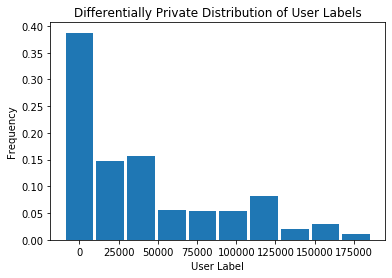

In [13]:
import warnings
warnings.filterwarnings('ignore')
dp_hist, dp_bins = dptools.histogram(LondonCheckinsClss['user'],epsilon=0.8)
dp_hist = dp_hist / dp_hist.sum()


ax=plt.subplot()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
ax.set_xlabel("User Label")
ax.set_ylabel("Frequency")
ax.set_title("Differentially Private Distribution of User Labels")
plt.show()

In [14]:
dp_hist, dp_bins = dptools.histogram(LondonCheckinsClss['user'], float("inf"))
dp_hist = dp_hist / dp_hist.sum()

print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())

Total histogram error: 0.000000


In [15]:
import warnings
warnings.filterwarnings('ignore')
accuracy = []
epsilons = np.logspace(-3, 1, 500)

for eps in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=eps)
    dp_clf.fit(X_train, y_train)
    accuracy.append(dp_clf.score(X_test, y_test))

In [16]:
import pickle
baseline = clss.score(X_train, y_train)
pickle.dump((epsilons, baseline, accuracy), open("lr_accuracy_500.p", "wb" ) )

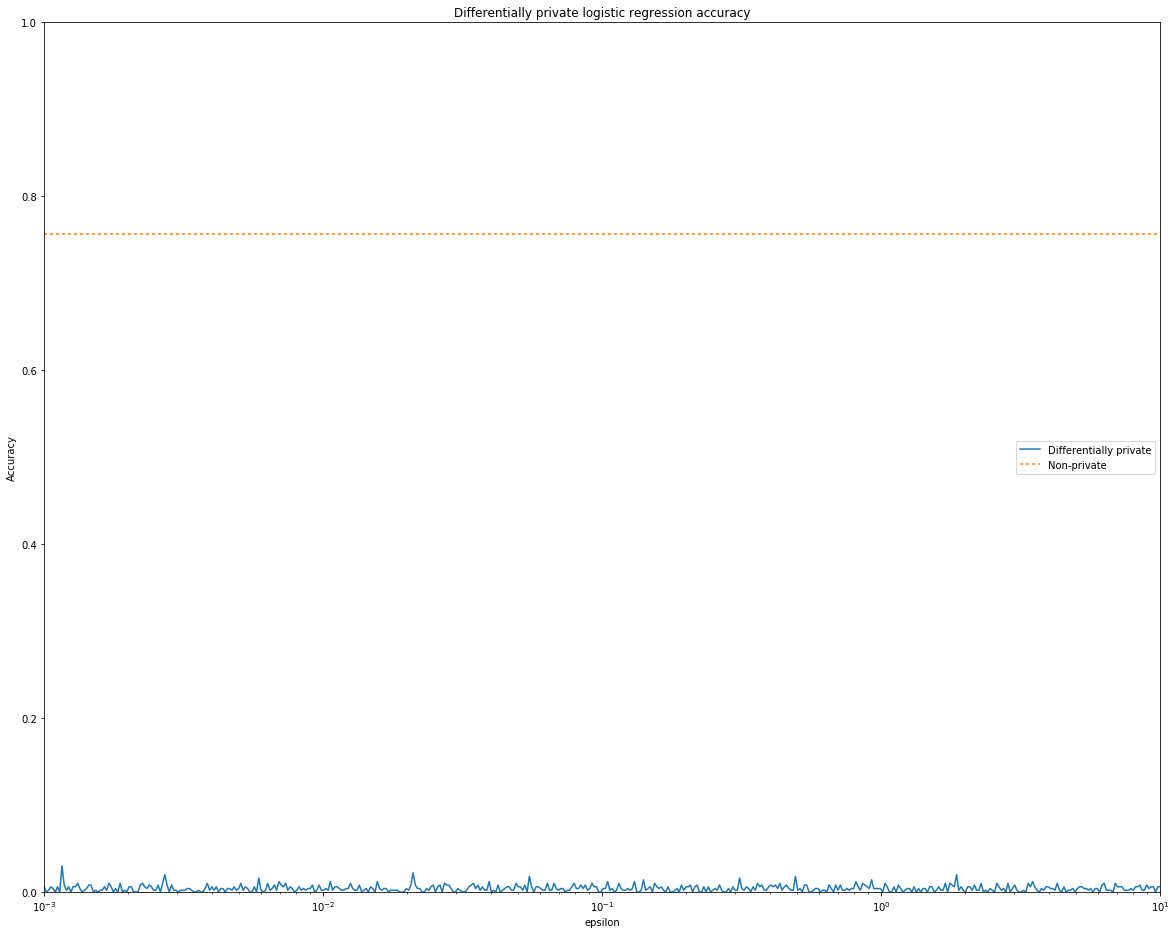

In [17]:
import matplotlib.pyplot as plt
import pickle
plt.figure(figsize=(20,16))
epsilons, baseline, accuracy = pickle.load(open("lr_accuracy_500.p", "rb"))

plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=7)
plt.show()

https://github.com/IBM/differential-privacy-library/blob/main/notebooks/logistic_regression.ipynb